# Digital Elevation Models

* **Products used:** 
[dem_cop_30](https://explorer.digitalearth.africa/products/dem_cop_30), [dem_cop_90](https://explorer.digitalearth.africa/products/dem_cop_90), [dem_srtm](https://explorer.digitalearth.africa/products/dem_srtm), [dem_srtm_deriv](https://explorer.digitalearth.africa/products/dem_srtm_deriv)

## Background

**D**igital **E**levation **M**odels (DEMs) provide information on bare ground topography, that is, elevation irrespective of land cover such as buildings/trees. DEMs are often derived from Light Detection and Ranging (LiDAR) data sources. DEMs are used in several applications such as understanding how climatic variables change with topography.

**Important details:**

There are four DEM products available from the Open Data Cube. The [Copernicus products](https://spacedata.copernicus.eu/web/cscda/dataset-details?articleId=394198) come from the European Space Agency (ESA) and the [Shuttle Radar Topography Mission (SRTM)](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-shuttle-radar-topography-mission-srtm-1-arc?qt-science_center_objects=0#qt-science_center_objects) products are from the United States Geological Survey (USGS):
* Copernicus DEM 30 m
    * Elevation data in 30 m resolution
* Copernicus DEM 90 m
    * Elevation data in 90 m resolution
* DEM SRTM 
    * Elevation data in 1-arc second (~30 m)
* DEM SRTM Derivatives
    * Derivatives of the 1-arc second DEM which include:
        * Percent slope; this is the rate of elevation change, so mathematically speaking it is the first/primary derivative of elevation.
        * Multi-resolution Valley Bottom Flatness (MrVBF); this identifies valley bottoms (areas of deposition). Zero values indicate erosional terrain and values ≥1 and indicate progressively larger areas of deposition.
        * Multi-resolution Ridge Top Flatness (MrRTF); complementary to MrVBF, zero values indicate areas that are steep or low, and values ≥1 indicate progressively larger areas of high flat land.
    * For further details on how these measurements was calculated see the [DEM derivatives repository](https://github.com/digitalearthafrica/dem-derivative)

## Description

In this notebook we will load DEM data using `dc.load()` to return a map of elevation and DEM derivatives, such as slope, for a specified area.

Topics covered include:
1. Inspecting the DEM product available in the datacube
2. Using the `dc.load()` function to load in DEM data
3. Plotting DEM and derivatives
4. An example analysis which compares temperature at high and low elevation

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline

import datacube
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from deafrica_tools.plotting import display_map
from deafrica_tools.load_era5 import load_era5
from odc.algo import xr_reproject

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="DEM")

### List measurements

The table below lists the products and measurements available for the DEM datasets indexed within DE Africa's datacube. We can see that the first three products contain a single measure for elevation, expressed in metres. The derivatives product comprises percent slope, multi-resolution valley bottom flatness (mrvbf), and multi-resolution ridge top flatness (mrrtf). 

In [3]:
product_name = ['dem_cop_30', 'dem_cop_90', 'dem_srtm', 'dem_srtm_deriv'] 

dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name].drop('flags_definition', axis=1)

name    dtype  units   nodata aliases
product        measurement                                            
dem_cop_30     elevation    elevation  float32      1      NaN     NaN
dem_cop_90     elevation    elevation  float32      1      NaN     NaN
dem_srtm       elevation    elevation    int16  metre -32768.0     NaN
dem_srtm_deriv mrvbf            mrvbf    int16      1 -32768.0     NaN
               mrrtf            mrrtf    int16      1 -32768.0     NaN
               slope            slope  float32      1  -9999.0     NaN

## Data loading parameters for Mt Kilimanjaro

In [4]:
lat, lon = -3.0674, 37.3556 #Mt Kilimanjaro
buffer = 0.3

resolution=(-30, 30) #resample so we can view a large area

measurements='elevation'

#convert the lat,lon,buffer into a range
lons = (lon - buffer, lon + buffer)
lats = (lat - buffer, lat + buffer)

In [5]:
display_map(x=lons, y=lats)

In [6]:
query = {
    'x': lons,
    'y': lats,
    'resolution':resolution,
    'output_crs': 'epsg:6933',
    'measurements':measurements
}

#load the dem 30 m product
ds = dc.load(product="dem_cop_30", **query).squeeze()

In [7]:
ds

<xarray.Dataset>
Dimensions:      (y: 2549, x: 1931)
Coordinates:
    time         datetime64[ns] 2000-01-01T12:00:00
  * y            (y) float64 -3.529e+05 -3.529e+05 ... -4.293e+05 -4.293e+05
  * x            (x) float64 3.575e+06 3.575e+06 ... 3.633e+06 3.633e+06
    spatial_ref  int32 6933
Data variables:
    elevation    (y, x) float32 1.147e+03 1.146e+03 1.148e+03 ... 851.2 854.4
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

### Plot elevation

We can generate a basic plot of elevation below. The summit of Mt Kilimanjaro is 5,895m.

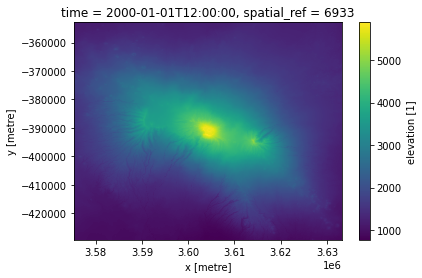

In [8]:
ds.elevation.plot()

Now we can load the derivative dataset with the same parameters, except measurements.

In [9]:
measurements=['mrvbf', 'mrrtf', 'slope'] # We just need to change the measurements parameter, lats, lon, crs etc. can remain the same. 

query = {
    'x': lons,
    'y': lats,
    'resolution':resolution,
    'output_crs': 'epsg:6933',
    'measurements':measurements
}

lons = (lon - buffer, lon + buffer)
lats = (lat - buffer, lat + buffer)
ds_deriv = dc.load(product="dem_srtm_deriv", **query).squeeze()

In [10]:
ds_deriv

<xarray.Dataset>
Dimensions:      (y: 2549, x: 1931)
Coordinates:
    time         datetime64[ns] 2000-01-01T12:00:00
  * y            (y) float64 -3.529e+05 -3.529e+05 ... -4.293e+05 -4.293e+05
  * x            (x) float64 3.575e+06 3.575e+06 ... 3.633e+06 3.633e+06
    spatial_ref  int32 6933
Data variables:
    mrvbf        (y, x) int16 2 1 0 0 3 4 4 3 3 3 3 3 ... 0 1 0 0 0 1 2 2 2 1 1
    mrrtf        (y, x) int16 0 0 1 1 0 0 0 0 0 0 1 0 ... 2 2 1 0 0 0 0 0 0 0 0
    slope        (y, x) float32 7.383 12.15 13.24 10.62 ... 2.5 4.29 8.271 9.148
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

### Plot derivatives

Plotting the three derivative measurements below shows areas of greater steepness around Mt Kilimanjaro. Most of the mountain has a 0 value for valley bottom and ridge tip flatness, whereas surrounding areas are identified as valleys and flat ridge tops.

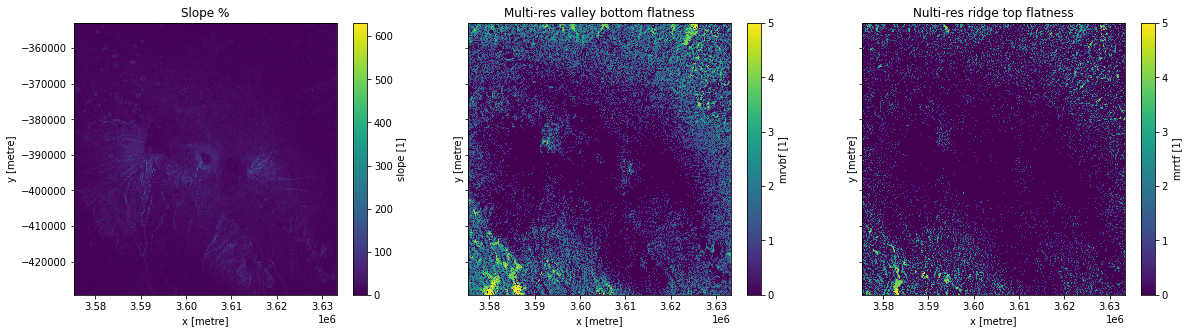

In [11]:
fig,ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
ds_deriv.slope.plot(ax=ax[0])
ds_deriv.mrvbf.plot(ax=ax[1])
ds_deriv.mrrtf.plot(ax=ax[2])

ax[0].set_title('Slope %')
ax[1].set_title('Multi-res valley bottom flatness')
ax[2].set_title('Nulti-res ridge top flatness');

## Analysis example: masking based on elevation

We can use elevation information to select or mask areas for analysis. In this example, we will compare climatic information between higher and lower elevation at the Virunga Mountains, a chain of volcanoes in Rwanda.

In [12]:
lat, lon = -1.4310, 29.5262
buffer = 0.2

resolution=(-90, 90) 

measurements='elevation'

#convert the lat,lon,buffer into a range
lons = (lon - buffer, lon + buffer)
lats = (lat - buffer, lat + buffer)

In [13]:
display_map(x=lons, y=lats)

In [14]:
query = {
    'x': lons,
    'y': lats,
    'resolution':resolution,
    'output_crs': 'epsg:6933',
    'measurements':measurements
}

#load the dem
ds = dc.load(product="dem_cop_90", **query).squeeze() # Using 90 m product for better computation times

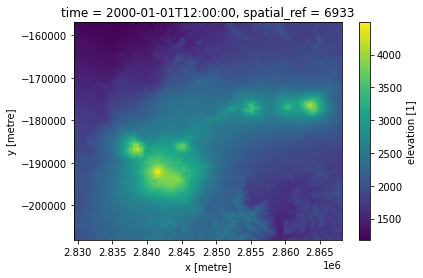

In [15]:
ds.elevation.plot()

### Mask analysis to high and low elevation

For this analysis, we will split the dataset into areas above and below 2,000m in elevation. In the plot below we can see that this separates the chain of volcanoes from surrounding lowland.

In [16]:
ds = ds.assign(high=xr.where(ds.elevation >= 2000, 1, 0))
ds = ds.assign(low=xr.where(ds.elevation < 2000, 1, 0))

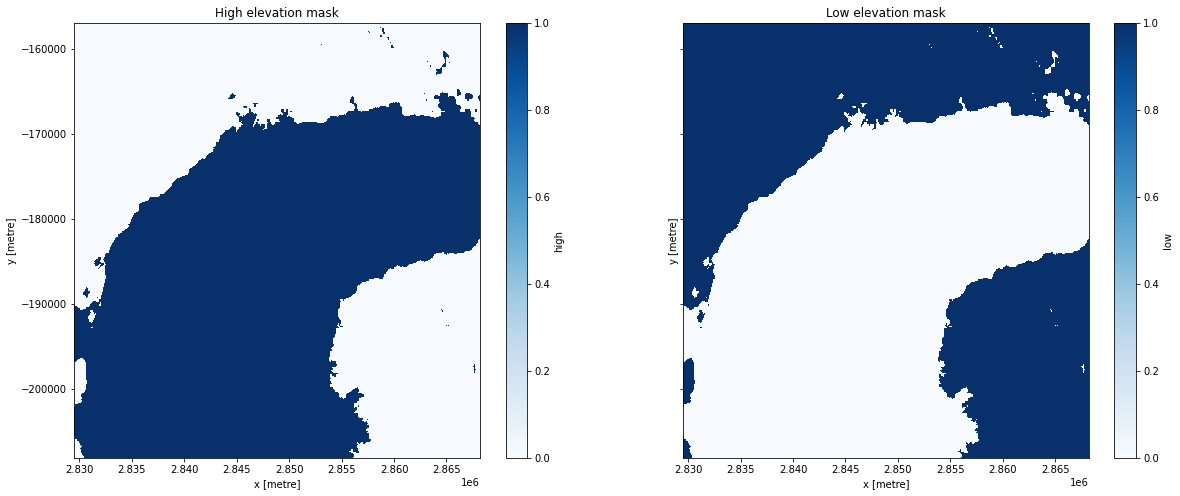

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
ds.high.plot(cmap='Blues', ax=axes[0])
ds.low.plot(cmap='Blues', ax=axes[1])
axes[0].set_title('High elevation mask')
axes[1].set_title('Low elevation mask');

### Load temperature data and compare between high and low elevation

We will use the `load_era5` function to load temperature data. More information on loading and using climate data can be found in the Climate_Data_ERA5_AWS Datasets notebook.

In [18]:
time = time = '2021-01', '2021-03'  # first three months of 2021 
temp_var = 'air_temperature_at_2_metres'
temp_mean = load_era5(temp_var, lats, lons, time, reduce_func=np.mean, resample='1D').compute()-273.15 # Convert Kelvin to Celsius

To make our calculation we will need to reproject the climate data so it matches the elevation data. We use the `xr_reproject` function to do this. More information on reprojecting datacube data is available [here](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Frequently_used_code/Reprojecting_data.html).

In [19]:
temp_mean_reprojected = xr_reproject(temp_mean, ds.geobox, resampling="average")

We can see that average daily temperature tends to be lower at the altitudes >2,000m for our analysis area, according to the ERA5 reanalysis product.

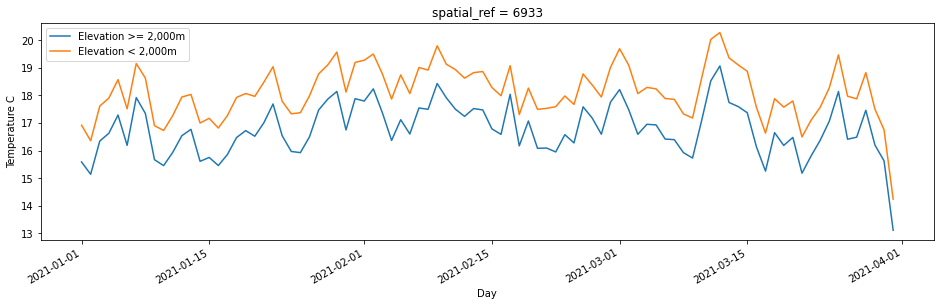

In [20]:
ds = ds.merge(temp_mean_reprojected, ds)
ds_high = ds.where(ds.squeeze().high)
high_mean_airtemp = ds_high.air_temperature_at_2_metres.mean(['x','y'])
ds_low = ds.where(ds.squeeze().low)
low_mean_airtemp = ds_low.air_temperature_at_2_metres.mean(['x','y'])

ds_high.air_temperature_at_2_metres.mean(['x','y']).plot(figsize = (16,4), label='Elevation >= 2,000m');
ds_low.air_temperature_at_2_metres.mean(['x','y']).plot(label='Elevation < 2,000m');
plt.legend();
plt.xlabel('Day');
plt.ylabel('Temperature C');

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [21]:
print(datacube.__version__)

1.8.6


**Last tested:**

In [22]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-11-04'